In [ ]:
!pip install bertopic
!pip install convokit
!pip install langchain
!pip install transformers
!pip install firebase-admin
!pip install transformers

In [ ]:
from bertopic import BERTopic
from convokit import Corpus, download
import pandas as pd
import numpy as np
from langchain.llms import HuggingFaceHub
import os
from transformers import pipeline
import firebase_admin
from firebase_admin import credentials, firestore, initialize_app, storage
from transformers import pipeline
import matplotlib.pyplot as plt

In [ ]:
cred = credentials.Certificate("/content/ming-527ed-firebase-adminsdk-z38ui-431c72dad9.json")
firebase_admin.initialize_app(cred)

In [ ]:
db = firestore.client()

# Loading Corpus

In [ ]:
corpus = Corpus(filename=download("conversations-gone-awry-corpus"))

In [ ]:
conversations_df = corpus.get_conversations_dataframe()
utterances_df = corpus.get_utterances_dataframe()
speakers_df = corpus.get_speakers_dataframe()

In [ ]:
utterances_df

In [ ]:
def process_conversations(conversations_df, utterances_df, speakers_df):
    # Filter and merge dataframes
    merged_df = pd.merge(utterances_df, speakers_df, left_on='speaker', right_index=True)
    merged_df = pd.merge(merged_df, conversations_df, left_on='conversation_id', right_index=True)

    # Process each conversation

    convo_records = []
    convo_texts = []
    for convo_id, convo_data in merged_df.groupby('conversation_id'):
        # Calculate total personal attacks and average toxicity
        total_attacks = convo_data['meta.comment_has_personal_attack'].sum()
        avg_toxicity = convo_data['meta.toxicity'].mean()

        # Get conversation start time
        start_time = convo_data['timestamp'].min()

        # Calculate embeddings for the conversation
        convo_text = ' '.join(convo_data['text'].tolist())
        #embeddings = calculate_embeddings(convo_text)

        # Prepare data for Firebase
        convo_record = {
            'convo_id': convo_id,
            'total_personal_attacks': total_attacks,
            'average_toxicity': avg_toxicity,
            'start_time': start_time,
            #'embeddings': embeddings,
            # Include additional metadata as needed
        }


        #convo_speakers.append(convo_speaker)
        convo_texts.append(convo_text)
        convo_records.append(convo_record)
        # Save to Firebase
        #db.collection('conversations').document(convo_id).set(convo_record)

    print("Processed Convo Texts")
    return convo_records, convo_texts

meaningfull labels
similarities for the clusters
emotions model to work on classifying speakers on emotions. then turn the emotions




In [ ]:
convo_records, convo_texts = process_conversations(conversations_df, utterances_df, speakers_df) #.head(1000)

# Do Clustering

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(stop_words="english")
topic_model = BERTopic(embedding_model="all-MiniLM-L6-v2",vectorizer_model=vectorizer_model)#calculate_probabilities=True)

In [ ]:
topics, probs = topic_model.fit_transform(convo_texts)

In [ ]:
topic_model.get_topic_info()

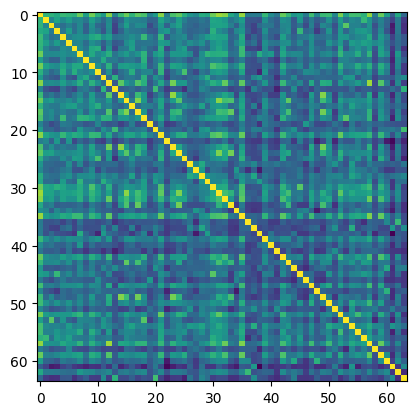

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

distance_matrix = cosine_similarity(np.array(topic_model.topic_embeddings_)[:, :])
labels = (topic_model.get_topic_info().sort_values("Topic", ascending=True).Name)[1:]
plt.imshow(distance_matrix)

In [ ]:
topic_list = topic_model.topic_labels_

topic_list.keys()

# Set Up Data for Firebase

In [ ]:
label_records = []

for i in topic_list.keys():
  label_record = {}
  label_record['topic'] = i
  topic_words = [token[0] for token in topic_model.get_topic(i)]
  topic_name = topic_words[0]
  for topic_word in topic_words[1:4]:
    topic_name += "_" + topic_word
  label_record['topic_name'] = topic_name

  sim = distance_matrix[i+1]
  for j in range(len(sim)):
    label_record[str(j-1)] = float(sim[j])

  label_records.append(label_record)

for i in range(len(convo_records)):
    convo_records[i]['topic'] = topics[i]

    topic_words = [token[0] for token in topic_model.get_topic(topics[i])]
    topic_name = topic_words[0]
    for topic_word in [token[0] for token in topic_model.get_topic(topics[i])][1:4]:
      topic_name += "_" + topic_word

    convo_records[i]['topic_name'] = topic_name
    convo_records[i]['probs_per_topic'] = probs[i]

In [ ]:
label_records[6]

In [ ]:
convo_records[0]

## Filter out conversations by labels to make it easier to send to firebase

In [ ]:
sorted_conv = {}
for record in label_records:
  for conv in convo_records:
    if record['topic'] == conv['topic']:
      if record['topic'] not in sorted_conv.keys():
        sorted_conv[record['topic']] = [conv]
      else:
        sorted_conv[record['topic']].append(conv)

In [ ]:
sorted_conv[2][1]

{'convo_id': '113637694.52.52',
 'total_personal_attacks': 1,
 'average_toxicity': nan,
 'start_time': 1173381372.0,
 'topic': 2,
 'topic_name': 'men_characters_episode_episodes',
 'probs_per_topic': 1.0}

## Save to Firebase

In [ ]:
for i, label_record in enumerate(label_records):
    topic = label_record['topic']
    topic_id = str(i)
    db.collection('topics').document(topic_id).set(label_record)
    for j, convo_record in enumerate(sorted_conv[topic]):
        convo_id = convo_record['convo_id']
        db.collection('topics').document(topic_id).collection('convosations').document(convo_id).set(convo_record)
print('done')

In [ ]:
for i, record in enumerate(convo_records):
    convo_id = record['convo_id']
    db.collection('convo_topics').document(convo_id).set(record)